
---

# Análise exploratória de dados: Retail Sales Dataset
Dataset Kaggle: [Retail Sales Dataset](https://www.kaggle.com/datasets/mohammadtalib786/retail-sales-dataset) <br>
Projeto no Kaggle: [Meu Projeto](https://www.kaggle.com/code/nerdygames/aed-retail-sales-dataset-pt-br) <br>
Autor: Bruno Pereira <br>

---

## 1. Contexto

**Descrição do Problema/Base de dados:** Este dataset contém dados fictícios de vendas do varejo e características dos compradores, permitindo que consigamos extrair insights além de obter uma compreensão mais profunda do comportamento de compra dos clientes. Meu objetivo é fazer uma análise exploratória desses dados e traduzi-los em insights valiosos e buscar estratégias para que consigamos aumentar as vendas da empresa.

Explicação de cada uma das colunas do dataset
1. **Transaction ID(ID da transação):** Um identificador único para cada transação, permitindo rastreamento e referência.

2. **Date(Data):** A data em que a transação ocorreu, fornecendo insights sobre as tendências de vendas ao longo do tempo.

3. **Customer ID(ID do Cliente):** Um identificador exclusivo para cada cliente, permitindo uma análise centrada no cliente.

4. **Gender(Gênero):** O gênero do cliente (masculino/feminino), oferecendo insights sobre padrões de compra baseados em gênero.

5. **Age(Idade):** A idade do cliente, facilitando a segmentação e exploração de influências relacionadas à idade.

6. **Product Category(Categoria do Produto):** A categoria do produto adquirido (Ex.: Eletrônicos, Roupas, Beleza), ajudando a entender as preferências do produto.

7. **Quantity(Quantidade):** O número de unidades do produto adquirido, contribuindo para insights sobre os volumes de compra.

8. **Price per Unit(Preço por Unidade):** O preço de uma unidade do produto, auxiliando nos cálculos relativos ao gasto total.

9. **Total Amount(Valor da Compra):** O valor monetário total da transação, mostrando o impacto financeiro de cada compra.

**OBS**: Durante minhas análises utilizarei o valor monetário **\$**(Dólar)

## 2. Pacotes, bibliotecas & Importações

Pacotes utilizados

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
import warnings

# Ignorar todos os warnings
warnings.simplefilter("ignore")

Funções desenvolvidas que serão utilizadas

In [45]:
# Definindo palheta de cores fixas para os atributos categóricos
palette_product_category = {
    "Clothing": "#ff9999",   # Vermelho claro
    "Electronics": "#66b3ff", # Azul claro
    "Beauty": "#99ff99"      # Verde claro
}

palete_gender = {
    'Female': "#f25f9a", # Rosa claro
    'Male': "#e6f4f1" # Branco
}

# Função utilizada para verificar os valores únicos
def verifica_valores_unicos(DataFrame: pd.DataFrame, colunas_ignoradas: list|str|None) -> None:
    for x in DataFrame.columns:
    
        if type(colunas_ignoradas) == str:
            if x != colunas_ignoradas:
                print('++'*30)
                print(f'NOME DA COLUNA COLUNA: "{x}"')
                print('--'*5)
                print('VALORES ÚNICOS:')
                print(f'{DataFrame[x].unique()}')
                print('--'*5)
                print(f'CONTAGEM DOS VALORES ÚNICOS: {len(DataFrame[x].unique())}')
                print('++'*30)
                print('\n')
        
        elif type(colunas_ignoradas) == list:
            if x not in colunas_ignoradas:
                print('++'*30)
                print(f'NOME DA COLUNA COLUNA: "{x}"')
                print('--'*5)
                print('VALORES ÚNICOS:')
                print(f'{DataFrame[x].unique()}')
                print('--'*5)
                print(f'CONTAGEM DOS VALORES ÚNICOS: {len(DataFrame[x].unique())}')
                print('++'*30)
                print('\n')

        else:
            print('++'*30)
            print(f'NOME DA COLUNA COLUNA: "{x}"')
            print('--'*5)
            print('VALORES ÚNICOS:')
            print(f'{DataFrame[x].unique()}')
            print('--'*5)
            print(f'CONTAGEM DOS VALORES ÚNICOS: {len(DataFrame[x].unique())}')
            print('++'*30)
            print('\n')
# Cria o gráfico de BoxPlot
def gerador_boxplot(data, y: str, x: str = None, eixos=None, valor_eixos: int | list = 0, title: str = "", y_label: str = "", palette=None ) -> None:
    
    if isinstance(eixos, int):  # Correção: usar isinstance() para verificar tipos
        sns.boxplot(data=data, y=y, x=x, color='skyblue', palette=palette, ax=eixos[valor_eixos])
        eixos[valor_eixos].set_title(title, fontsize=12)
        eixos[valor_eixos].set_ylabel(y_label, fontsize=10)
    else:
        sns.boxplot(data=data, y=y, x=x, color='skyblue', palette=palette, ax=eixos[valor_eixos[0]][valor_eixos[1]])
        eixos[valor_eixos[0]][valor_eixos[1]].set_title(title, fontsize=12)
        eixos[valor_eixos[0]][valor_eixos[1]].set_ylabel(y_label, fontsize=10)

# Cria o rótulo de dados de cada barra (No topo da barra)
def cria_rotulos_barras(histrgrama, grid, posicao_grid: int|list, fontsize: int, binwidth_value: int) -> None:
    
    for p in histrgrama.patches:
        
        height = p.get_height() # 'Altura' da barra, nesse caso a frequência
        
        if type(posicao_grid) == int:
            # Adicionar rótulo da frequência (no topo da barra)
            if height != 0: # Não adiciona o rótulo caso a barra exteja com o valor zerado
                grid[posicao_grid].annotate(f"{int(height)}", 
                                (p.get_x() + binwidth_value / 2, height + 1), 
                                ha="center", fontsize=fontsize, fontweight="bold")
        else:
            # Adicionar rótulo da frequência (no topo da barra)
            if height != 0: # Não adiciona o rótulo caso a barra exteja com o valor zerado
                grid[posicao_grid[0]][posicao_grid[1]].annotate(f"{int(height)}", 
                                (p.get_x() + binwidth_value / 2, height + 1), 
                                ha="center", fontsize=fontsize, fontweight="bold")

# Cria o rótulo do intervalo de cada bin do histograma (Dentro da barra)
def rotula_intervalo_bins(DataFrame: pd.DataFrame, column:str, histrgrama, grid ,posicao_grid: int|list, fontsize: int, binwidth_value: int) -> None:

    max_value = DataFrame[column].max()
    for p in histrgrama.patches:
        
        height = p.get_height()  # 'Altura' da barra, ou seja, a frequência

        bin_left = p.get_x()     # Valor esquerdo do bin
        bin_right = bin_left + binwidth_value  # Limite direito do bin (exclusivo)

        # Ajustar o último rótulo se bin_right ultrapassar max_value (Podem haver casos em que o último bin seja maior)
        if bin_right >= max_value:
            bin_right = max_value  # Último bin terminará no valor máximo real
            bin_range_label = f"{int(bin_left)} - {int(bin_right)}"
        else:
            # Criar o rótulo do intervalo [bin_left, bin_right - 1], isso pois a frequência do histgrama e os rótulos estavam divergentes
            bin_range_label = f"{int(bin_left)} - {int(bin_right) - 1}"

        if type(posicao_grid) == int:
            if height != 0:  # Não adiciona o rótulo caso a barra exteja com o valor zerado
                # Adicionar rótulo do intervalo (dentro da barra)
                grid[posicao_grid].annotate(bin_range_label, 
                                    (p.get_x() + binwidth_value / 2, height / 2), 
                                    ha='center', va='center', fontsize=fontsize, color='black', rotation=90)
        else:
            if height != 0:  # Não adiciona o rótulo caso a barra exteja com o valor zerado
                # Adicionar rótulo do intervalo (dentro da barra)
                grid[posicao_grid[0]][posicao_grid[1]].annotate(bin_range_label, 
                                    (p.get_x() + binwidth_value / 2, height / 2), 
                                    ha='center', va='center', fontsize=fontsize, color='black', rotation=90)

# Cria o rótulo percentual de cada um dos segmentos das barras (Dentro da barra)
def rotula_percentual_segmentado_barras(histograma, grid, posicao_grid:int|list, fontsize: int) -> None:

    # Criar um dicionário para armazenar a soma de valores de cada bin
    bin_totals = {}

    # Primeira passada para obter os totais por bin
    for patch in histograma.patches:
        x_start = patch.get_x()
        x_end = x_start + patch.get_width()
        bin_mid = (x_start + x_end) / 2  # Centro do bin

        if bin_mid not in bin_totals:
            bin_totals[bin_mid] = 0
        bin_totals[bin_mid] += patch.get_height()  # Soma os valores do bin

    # Segunda passada para adicionar os rótulos percentuais
    for patch in histograma.patches:
        height = patch.get_height()
        x_start = patch.get_x()
        x_end = x_start + patch.get_width()
        bin_mid = (x_start + x_end) / 2  # Centro do bin

        if type(posicao_grid) == int:
            if height > 0:
                percent = (height / bin_totals[bin_mid]) * 100  # Calcula percentual
                grid[posicao_grid].text(bin_mid, patch.get_y() + height / 2, f'{percent:.1f}%', ha='center', va='center', fontsize=fontsize, color='black', rotation=90)
        else:
            if height > 0:
                percent = (height / bin_totals[bin_mid]) * 100  # Calcula percentual
                grid[posicao_grid[0]][posicao_grid[1]].text(bin_mid, patch.get_y() + height / 2, f'{percent:.1f}%', ha='center', va='center', fontsize=fontsize, color='black', rotation=90)

## 3. Exploração Inicial dos dados

Leitura do dataset

In [ ]:
df = pd.read_csv("../Retail Sales Dataset.csv")

Visualização inicial dos dados

In [47]:
df.head()

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    1000 non-null   int64 
 1   Date              1000 non-null   object
 2   Customer ID       1000 non-null   object
 3   Gender            1000 non-null   object
 4   Age               1000 non-null   int64 
 5   Product Category  1000 non-null   object
 6   Quantity          1000 non-null   int64 
 7   Price per Unit    1000 non-null   int64 
 8   Total Amount      1000 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 70.4+ KB


**Conclusão:** Podemos notar que o DataFrame é bom limpo e consistente, sendo necessário apenas algumas conversões do tipo de alguns dados e talvez excluir algumas colunas. Notamos também que a maioria dos atributos são do tipo numérico, especificamente numéricos discretos(```Total Amount```, ```Price per Unit```, ```Quantity```, ```Age```, ```Transaction ID```). Também existem duas colunas categóricas nominais(```Customer ID```, ```Gender```, ```Product Category```), e uma coluna de data(```Date```).

Utilização da função ```verifica_valores_unicos``` para entendermos mais profundamente como estão distribuídos os dados em cada um dos atributos

In [49]:
verifica_valores_unicos(df, colunas_ignoradas=['Date','Price per Unit','Total Amount'])

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
NOME DA COLUNA COLUNA: "Transaction ID"
----------
VALORES ÚNICOS:
[   1    2    3    4    5    6    7    8    9   10   11   12   13   14
   15   16   17   18   19   20   21   22   23   24   25   26   27   28
   29   30   31   32   33   34   35   36   37   38   39   40   41   42
   43   44   45   46   47   48   49   50   51   52   53   54   55   56
   57   58   59   60   61   62   63   64   65   66   67   68   69   70
   71   72   73   74   75   76   77   78   79   80   81   82   83   84
   85   86   87   88   89   90   91   92   93   94   95   96   97   98
   99  100  101  102  103  104  105  106  107  108  109  110  111  112
  113  114  115  116  117  118  119  120  121  122  123  124  125  126
  127  128  129  130  131  132  133  134  135  136  137  138  139  140
  141  142  143  144  145  146  147  148  149  150  151  152  153  154
  155  156  157  158  159  160  161  162  163  164  165  166  167  168
  169  170  171  172

Também existe uma coluna de data, vamos entender inicialmente o período temporal que esse dataset contempla

In [50]:
df['Date'].min(), df['Date'].max()

('2023-01-01', '2024-01-01')

**Conclusão**: Existem apenas duas linhas que são referentes a 2024, como nossa amostra possui uma quantidade de linhas considerável, na etapa de wrangling farei a exclusão das linhas correspondentes a 2024 para que possamos fazer uma análise apenas do ano de 2023

## 4. Wrangling

Depois dessa breve análise faremos alguns tratamentos, iniciando com a exclusão de algumas colunas que não impactarão em nossas futuras análises, sendo elas: ```Customer ID``` e ```Transaction ID```

In [51]:
df.drop(columns=['Transaction ID', 'Customer ID'], inplace=True)

Também faremos as conversão dos valores dos atributos para seus respectivos tipos, isso deixa nossa base de dados mais otimizada consumindo menos recusos computacionais, por mais que nossa base é pequena é uma boa prática.

In [52]:
df['Date'] = pd.to_datetime(df['Date']) # Converter de object para datetime
df['Gender'] = df['Gender'].astype("category") # Converter de object para o tipo category
df['Product Category'] = df['Product Category'].astype("category") # Converter de object para o tipo category

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              1000 non-null   datetime64[ns]
 1   Gender            1000 non-null   category      
 2   Age               1000 non-null   int64         
 3   Product Category  1000 non-null   category      
 4   Quantity          1000 non-null   int64         
 5   Price per Unit    1000 non-null   int64         
 6   Total Amount      1000 non-null   int64         
dtypes: category(2), datetime64[ns](1), int64(4)
memory usage: 41.4 KB


Mantendo apenas as linhas com vendas feitas em 2023

In [54]:
df = df[df['Date'].dt.year == 2023] # Excluindo as linhas de vendas feitas em 2023

In [55]:
total_registros_df = len(df)
total_registros_df

998

## 5. Análise Exploratória

### Análise dos Atributos Categóricos

In [56]:
df.describe(include='category')

,Gender,Product Category
count,998,998
unique,2,3
top,Female,Clothing
freq,510,351


**Conclusão**: Nossa amostra contém duas colunas categóricas, ``Gender`` e ``Product Category``. Em uma análise inicial, observamos que o número de mulheres compradoras é ligeiramente superior ao de homens, embora a diferença seja pequena.

Além disso, identificamos que os produtos estão distribuídos em três categorias, sendo Roupas (Clothing) a mais predominante, representando aproximadamente 35% das transações. Essa distribuição sugere que a base de dados está relativamente equilibrada e representativa.

#### Análise exploratória dos atributos Categóricos

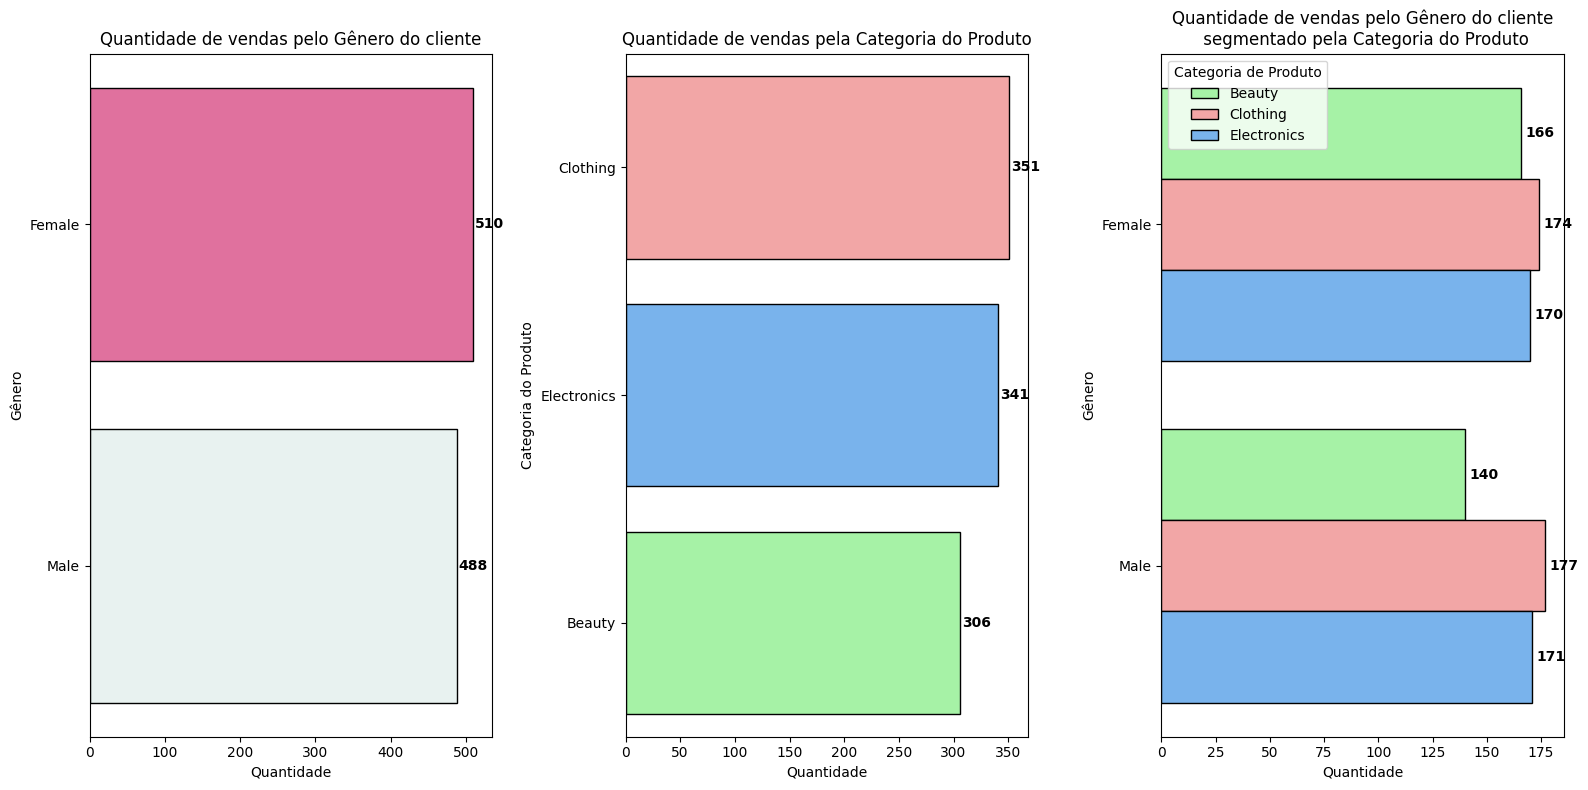

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 8)) # Criando um grid três gráficos lado a lado

# 🎯 Gráfico 1
gender_order = df["Gender"].value_counts().index  # Ordenar categorias pela contagem
sns.countplot(data=df, y="Gender", palette=palete_gender, edgecolor="black", ax=axes[0],order=gender_order)
axes[0].set_title("Quantidade de vendas pelo Gênero do cliente", fontsize=12)
axes[0].set_xlabel("Quantidade", fontsize=10)
axes[0].set_ylabel("Gênero", fontsize=10)

# Adicionar rótulos de valores dentro das barras
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_width())}', 
                     (p.get_width() + 2, p.get_y() + p.get_height()/2), 
                     ha='left', va='center', fontsize=10, fontweight="bold")

# 🎯 Gráfico 2
product_category_order = df["Product Category"].value_counts().index  # Ordenar categorias pela contagem
sns.countplot(data=df, y="Product Category", palette=palette_product_category, edgecolor="black", ax=axes[1], order=product_category_order)
axes[1].set_title("Quantidade de vendas pela Categoria do Produto", fontsize=12)
axes[1].set_xlabel("Quantidade", fontsize=10)
axes[1].set_ylabel("Categoria do Produto", fontsize=10)

# Adicionar rótulos de valores dentro das barras
for p in axes[1].patches:
    axes[1].annotate(f'{int(p.get_width())}', 
                     (p.get_width() + 2, p.get_y() + p.get_height()/2), 
                     ha='left', va='center', fontsize=10, fontweight="bold")

# 🎯 Gráfico 3
sns.countplot(data=df, y="Gender", hue="Product Category", palette=palette_product_category, edgecolor="black", ax=axes[2])
axes[2].set_title("Quantidade de vendas pelo Gênero do cliente\n segmentado pela Categoria do Produto", fontsize=12)
axes[2].set_xlabel("Quantidade", fontsize=10)
axes[2].set_ylabel("Gênero", fontsize=10)
axes[2].legend(title="Categoria de Produto", loc="upper left")  # Mover legenda para o canto superior esquerdo para facilitar a visualização

# Adicionar rótulos de valores dentro das barras do gráfico 3
for p in axes[2].patches:
    axes[2].annotate(f'{int(p.get_width())}', 
                     (p.get_width() + 2, p.get_y() + p.get_height()/2), 
                     ha='left', va='center', fontsize=10, fontweight="bold")

# Ajustar layout
plt.tight_layout()
plt.show()


**Explicação**: Podemos observar que as categorias de produtos em nossa base de dados estão bem distribuídas, sem grandes discrepâncias entre elas. Ao analisar a quantidade de vendas, segmentada por gênero e categoria do produto, identificamos uma distribuição equilibrada. No entanto, nota-se que os homens compram menos produtos da categoria ``Beauty`` (Beleza) em comparação às mulheres.

### Análise exploratória dos atributos Numéricos

In [58]:
df.describe(include='int64')

,Age,Quantity,Price per Unit,Total Amount
count,998.000000,998.000000,998.000000,998.000000
mean,41.377756,2.515030,179.719439,455.380762
std,13.688342,1.132751,189.541154,559.420064
min,18.000000,1.000000,25.000000,25.000000
25%,29.000000,1.000000,30.000000,60.000000
50%,42.000000,3.000000,50.000000,135.000000
75%,53.000000,4.000000,300.000000,900.000000
max,64.000000,4.000000,500.000000,2000.000000


**Conclusão**: Observamos que a idade dos clientes varia entre 18 e 64 anos, com uma média de 41 anos. Em relação ao volume de compras, os clientes adquirem, em média, de 2 a 3 produtos por transação, o que indica que raramente compram apenas um item, mas dificilmente ultrapassam quatro produtos.

Outro ponto de destaque é o preço por unidade, que apresenta um desvio padrão elevado. Isso sugere uma grande variação nos valores dos produtos, com itens significativamente acima ou abaixo da média, como é o caso de um produto que custa **\$500**.

Por fim, verificamos que o ticket médio por cliente é de aproximadamente **\$455**, indicando o valor médio gasto por compra na loja.

#### Atributo: ```Age```

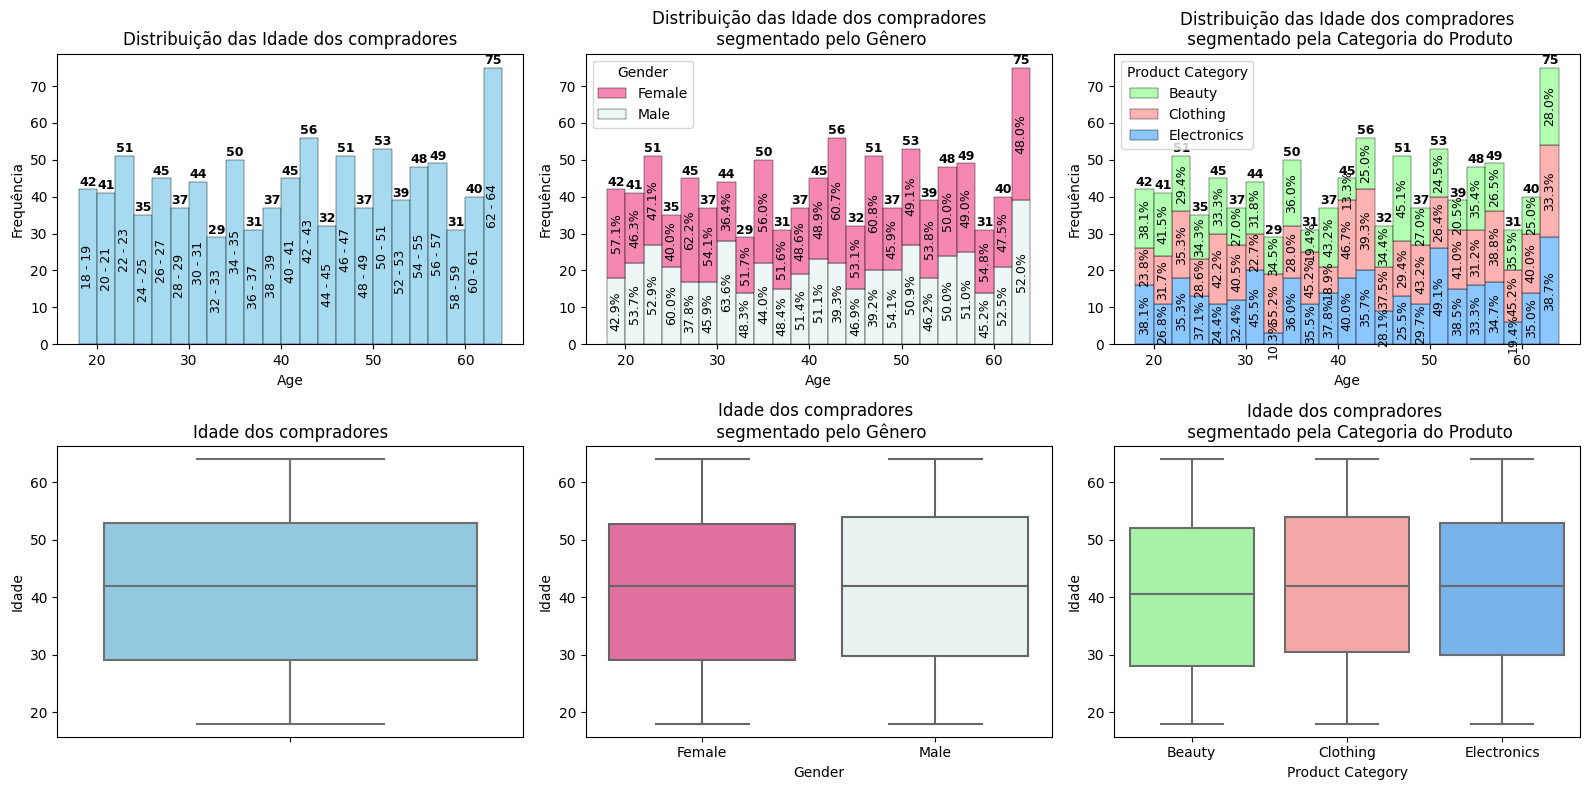

In [59]:
janela, graficos = plt.subplots(nrows=2, ncols=3, figsize=(16,8)) # Criação de um Grid 2x3 de gráficos

binwidth_value = 2
fontsize = 9

# 📌 Gráfico 1 (Histograma)
histplot = sns.histplot(data=df, x='Age', binwidth=2, ax=graficos[0][0], edgecolor="black", linewidth=0.3, color='skyblue')

cria_rotulos_barras(histrgrama=histplot, grid=graficos, posicao_grid=[0,0], fontsize=fontsize, binwidth_value=binwidth_value)

rotula_intervalo_bins(DataFrame=df, column='Age', histrgrama=histplot, grid=graficos, posicao_grid=[0,0], fontsize=fontsize, binwidth_value=binwidth_value)

graficos[0][0].set_title('Distribuição das Idade dos compradores', fontsize=12)
graficos[0][0].set_xlabel('Age', fontsize=10)
graficos[0][0].set_ylabel('Frequência', fontsize=10)

# 📌 Gráfico 2 (Histograma)
histplot2 = sns.histplot(data=df, x='Age', hue='Gender', binwidth=2, multiple="stack", ax=graficos[0][1], edgecolor="black", linewidth=0.3, palette=palete_gender)

cria_rotulos_barras(histrgrama=histplot, grid=graficos, posicao_grid=[0,1], fontsize=fontsize, binwidth_value=binwidth_value)

rotula_percentual_segmentado_barras(histograma=histplot2, grid=graficos, posicao_grid=[0,1], fontsize=fontsize)

graficos[0][1].set_title('Distribuição das Idade dos compradores\n segmentado pelo Gênero', fontsize=12)
graficos[0][1].set_xlabel('Age', fontsize=10)
graficos[0][1].set_ylabel('Frequência', fontsize=10)

# 📌 Gráfico 3 (Histograma)
histplot3 = sns.histplot(data=df, x='Age', hue='Product Category', binwidth=2,  multiple="stack", ax=graficos[0][2], edgecolor="black", linewidth=0.3, palette=palette_product_category)

cria_rotulos_barras(histrgrama=histplot, grid=graficos, posicao_grid=[0,2], fontsize=fontsize, binwidth_value=binwidth_value)

rotula_percentual_segmentado_barras(histograma=histplot3, grid=graficos, posicao_grid=[0,2], fontsize=fontsize)

graficos[0][2].set_title('Distribuição das Idade dos compradores\n segmentado pela Categoria do Produto', fontsize=12)
graficos[0][2].set_xlabel('Age', fontsize=10)
graficos[0][2].set_ylabel('Frequência', fontsize=10)

# 📌 Gráfico 1 (Boxplot)
sns.boxplot(data=df, y='Age', x=None, color='skyblue', ax=graficos[1][0])
graficos[1][0].set_title('Idade dos compradores', fontsize=12)
graficos[1][0].set_ylabel('Idade', fontsize=10)

# 📌 Gráfico 2 (Boxplot)
sns.boxplot(data=df, y='Age', x='Gender', palette=palete_gender ,ax=graficos[1][1])
graficos[1][1].set_title('Idade dos compradores \n segmentado pelo Gênero', fontsize=12)
graficos[1][1].set_ylabel('Idade', fontsize=10)

# 📌 Gráfico 3 (Boxplot)
sns.boxplot(data=df, y='Age', x='Product Category', palette=palette_product_category, ax=graficos[1][2])
graficos[1][2].set_title('Idade dos compradores \n segmentado pela Categoria do Produto', fontsize=12)
graficos[1][2].set_ylabel('Idade', fontsize=10)

# Exibir os gráficos
plt.tight_layout()
plt.show()

In [60]:
maior_frequencia_etaria = round((len(df.query("Age >= 60")) / total_registros_df) * 100, 2)
print(f'Clientes que possuém 60 ou mais anos representam {maior_frequencia_etaria}% da nossa base de dados')

Clientes que possuém 60 ou mais anos representam 11.52% da nossa base de dados


**Explicação**: Observamos que não há menores de idade na amostra, ou seja, todos os clientes têm 18 anos ou mais, com uma faixa etária variando entre 18 e 64 anos.

Destaca-se que a faixa etária com a maior quantidade de clientes está entre 62 e 64 anos, representando aproximadamente 7,5% do total. Além disso, 11,52% dos clientes têm 60 anos ou mais.

Por fim, não identificamos um insight claro ao segmentar os clientes por idade ou pela categoria do produto, indicando que a variável idade pode não ter um impacto significativo na distribuição das compras.

#### Atributo: ```Quantity```

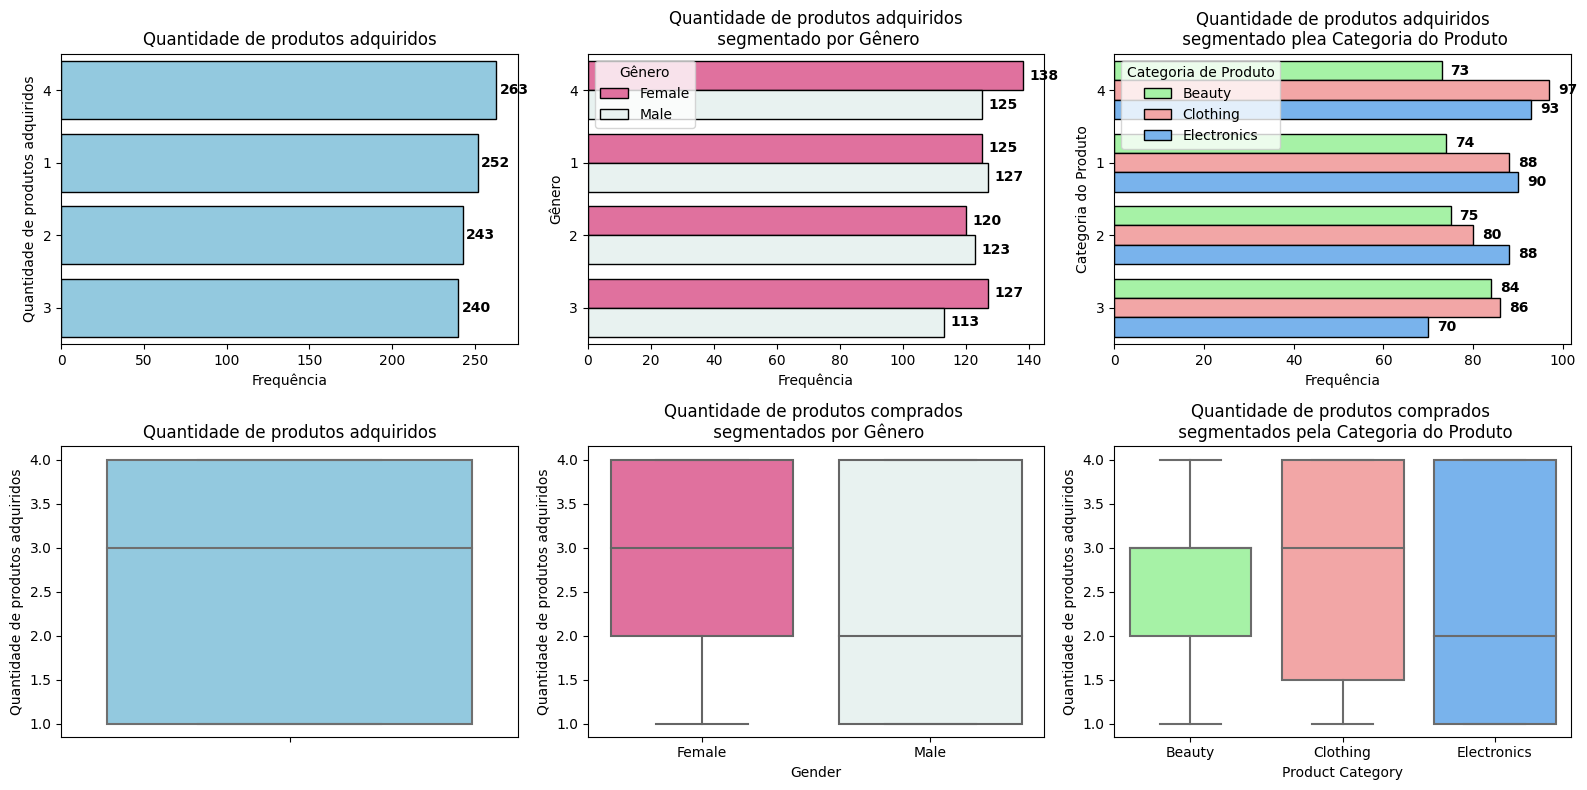

In [61]:
# Ordenação dos gráficos com base na frequência de compras por preço da unidade
order = df.groupby("Quantity")["Quantity"].value_counts().sort_values(ascending=False).index

fig, graficos = plt.subplots(nrows=2, ncols=3, figsize=(16, 8)) # Criação de um Grid 2x3 de gráficos

# 🎯 Gráfico 1 (Barras)
sns.countplot(data=df, y="Quantity", color='skyblue', edgecolor="black", order=order, ax=graficos[0][0])
graficos[0][0].set_title("Quantidade de produtos adquiridos", fontsize=12)
graficos[0][0].set_xlabel("Frequência", fontsize=10)
graficos[0][0].set_ylabel("Quantidade de produtos adquiridos", fontsize=10)

# Adicionar rótulos de valores dentro das barras
for p in graficos[0][0].patches:
    graficos[0][0].annotate(f'{int(p.get_width())}', 
                     (p.get_width() + 2, p.get_y() + p.get_height()/2), 
                     ha='left', va='center', fontsize=10, fontweight="bold")

# 🎯 Gráfico 2 (Barras)
sns.countplot(data=df, y="Quantity", hue="Gender", edgecolor="black", order=order, ax=graficos[0][1], palette=palete_gender)
graficos[0][1].set_title("Quantidade de produtos adquiridos\n segmentado por Gênero", fontsize=12)
graficos[0][1].set_xlabel("Frequência", fontsize=10)
graficos[0][1].set_ylabel("Gênero", fontsize=10)
graficos[0][1].legend(title="Gênero", loc="upper left")

# Adicionar rótulos de valores dentro das barras do gráfico 3
for p in graficos[0][1].patches:
    graficos[0][1].annotate(f'{int(p.get_width())}', 
                     (p.get_width() + 2, p.get_y() + p.get_height()/2), 
                     ha='left', va='center', fontsize=10, fontweight="bold")


# 🎯 Gráfico 3 (Barras)
sns.countplot(data=df, y="Quantity", hue="Product Category", edgecolor="black", order=order, ax=graficos[0][2], palette=palette_product_category)
graficos[0][2].set_title("Quantidade de produtos adquiridos\n segmentado plea Categoria do Produto", fontsize=12)
graficos[0][2].set_xlabel("Frequência", fontsize=10)
graficos[0][2].set_ylabel("Categoria do Produto", fontsize=10)
graficos[0][2].legend(title="Categoria de Produto", loc="upper left")

# Adicionar rótulos de valores dentro das barras
for p in graficos[0][2].patches:
    graficos[0][2].annotate(f'{int(p.get_width())}', 
                     (p.get_width() + 2, p.get_y() + p.get_height()/2), 
                     ha='left', va='center', fontsize=10, fontweight="bold")

# 🎯 Gráfico 4 (Boxplot)
gerador_boxplot(data=df, y='Quantity', eixos=graficos, valor_eixos=[1,0], title='Quantidade de produtos adquiridos', y_label='Quantidade de produtos adquiridos')
# 🎯 Gráfico 5 (Boxplot)
gerador_boxplot(data=df, y='Quantity', x='Gender', eixos=graficos, valor_eixos=[1,1], title='Quantidade de produtos comprados \n segmentados por Gênero', y_label='Quantidade de produtos adquiridos', palette=palete_gender)
# 🎯 Gráfico 6 (Boxplot)
gerador_boxplot(data=df, y='Quantity', x='Product Category', eixos=graficos, valor_eixos=[1,2], title='Quantidade de produtos comprados \n segmentados pela Categoria do Produto', y_label='Quantidade de produtos adquiridos', palette=palette_product_category)

# Ajustar layout
plt.tight_layout()
plt.show()


In [62]:
mais_de_um_protudo_adquirido = round((len(df[(df['Quantity']>1) & (df['Quantity']<=4)]) / total_registros_df) * 100, 2)
print(f'{mais_de_um_protudo_adquirido}% dos clientes adquiriram mais de 1 produto')

74.75% dos clientes adquiriram mais de 1 produto


**Explicação** Podemos observar alguns detalhes interessantes:

1. Em nossa amostra, aproximadamente 75% dos clientes compram mais de um produto por transação.
2. O comportamento de compra mais frequente (Moda) é a aquisição de 4 produtos por compra.
3. O público feminino se destaca, liderando os rankings de compras de 3 e 4 produtos por transação.
4. A categoria Beauty apresenta a menor quantidade de produtos adquiridos por compra em 3 dos 4 rankings. Além disso, é a categoria com menor variabilidade, conforme observado no terceiro gráfico de Boxplot.

#### Atributo: ```Price per Unit```

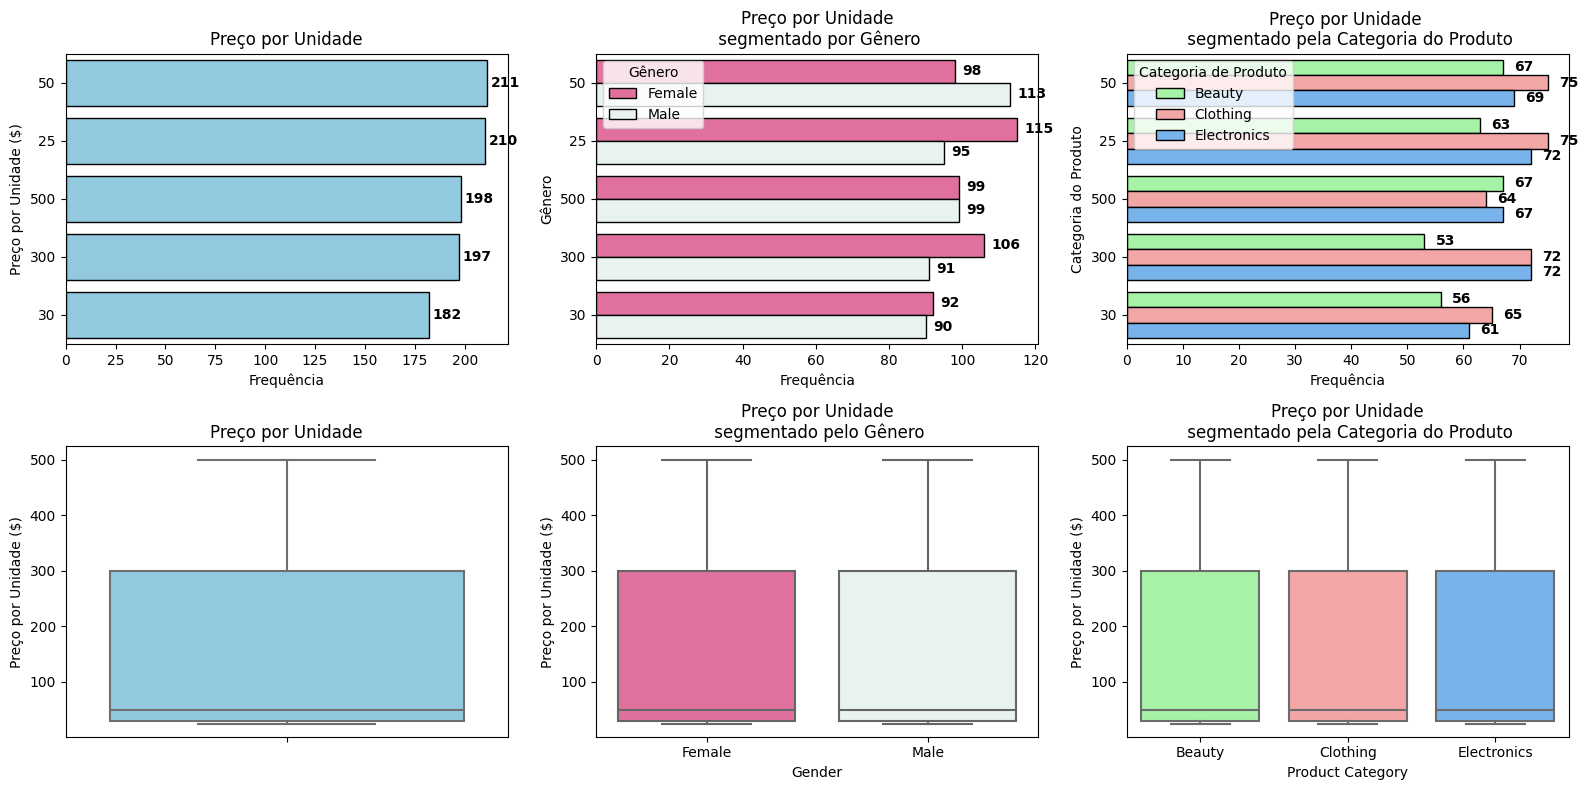

In [63]:
# Ordenação dos gráficos com base na frequência de compras por preço da unidade
order = df.groupby("Price per Unit")["Price per Unit"].value_counts().sort_values(ascending=False).index

fig, graficos = plt.subplots(nrows=2, ncols=3, figsize=(16, 8)) # Criação de um Grid 2x3 de gráficos

# 🎯 Gráfico 1 (Barras)
sns.countplot(data=df, y="Price per Unit", order=order ,color='skyblue', edgecolor="black", ax=graficos[0][0])
graficos[0][0].set_title("Preço por Unidade", fontsize=12)
graficos[0][0].set_xlabel("Frequência", fontsize=10)
graficos[0][0].set_ylabel("Preço por Unidade ($)", fontsize=10)

# Adicionar rótulos de valores dentro das barras
for p in graficos[0][0].patches:
        graficos[0][0].annotate(f'{int(p.get_width())}', 
                            (p.get_width() + 2, p.get_y() + p.get_height()/2), 
                            ha='left', va='center', fontsize=10, fontweight="bold")
        


# 🎯 Gráfico 2 (Barras)
sns.countplot(data=df, y="Price per Unit", order=order, hue="Gender", edgecolor="black", ax=graficos[0][1], palette=palete_gender)
graficos[0][1].set_title("Preço por Unidade\n segmentado por Gênero", fontsize=12)
graficos[0][1].set_xlabel("Frequência", fontsize=10)
graficos[0][1].set_ylabel("Gênero", fontsize=10)
graficos[0][1].legend(title="Gênero", loc="upper left")

# Adicionar rótulos de valores dentro das barras do gráfico 3
for p in graficos[0][1].patches:
    graficos[0][1].annotate(f'{int(p.get_width())}', 
                    (p.get_width() + 2, p.get_y() + p.get_height()/2), 
                    ha='left', va='center', fontsize=10, fontweight="bold")


# 🎯 Gráfico 3 (Barras)
sns.countplot(data=df, y="Price per Unit",hue="Product Category", order=order, edgecolor="black", ax=graficos[0][2], palette=palette_product_category)
graficos[0][2].set_title("Preço por Unidade \n segmentado pela Categoria do Produto", fontsize=12)
graficos[0][2].set_xlabel("Frequência", fontsize=10)
graficos[0][2].set_ylabel("Categoria do Produto", fontsize=10)
graficos[0][2].legend(title="Categoria de Produto", loc="upper left")

# Adicionar rótulos de valores dentro das barras
for p in graficos[0][2].patches:
    graficos[0][2].annotate(f'{int(p.get_width())}', 
                     (p.get_width() + 2, p.get_y() + p.get_height()/2), 
                     ha='left', va='center', fontsize=10, fontweight="bold")

# 🎯 Gráfico 4 (Boxplot)
gerador_boxplot(data=df, y='Price per Unit', eixos=graficos, valor_eixos=[1,0], title='Preço por Unidade', y_label='Preço por Unidade ($)')
# 🎯 Gráfico 5 (Boxplot)
gerador_boxplot(data=df, y='Price per Unit', x='Gender' ,eixos=graficos, valor_eixos=[1,1], title='Preço por Unidade\n segmentado pelo Gênero', y_label='Preço por Unidade ($)', palette=palete_gender)
# 🎯 Gráfico 6 (Boxplot)
gerador_boxplot(data=df, y='Price per Unit', x='Product Category' ,eixos=graficos, valor_eixos=[1,2], title='Preço por Unidade\n segmentado pela Categoria do Produto', y_label='Preço por Unidade ($)', palette=palette_product_category)

# Ajustar layout
plt.tight_layout()
plt.show()

In [64]:
produtos_menores_que_51 = (len(df[df['Price per Unit'] <= 50]) / total_registros_df) * 100

print(f'{format(produtos_menores_que_51, ".2f")}% dos preços dos produtos são menores ou iguais a 50')

60.42% dos preços dos produtos são menores ou iguais a 50


**Conclusão**: Analisando esse critério, notamos que a maioria dos produtos possuem valores mais baixos, com 60% custando **\$50** ou menos. Essa distribuição pode ser visualizada no gráfico de boxplot, onde a caixa está deslocada para a parte inferior, indicando a concentração de preços mais baixos.

O preço mais frequente é **\$50**, representando 21% de toda a amostra. Um fato interessante é que os produtos com preço de **\$30** são os menos adquiridos. Uma possível estratégia seria oferecer um desconto para **\$25** para aumentar a adesão do público ou analisar se faz sentido manter esse produto nas prateleiras.

#### Atributo: ```Total Amount```

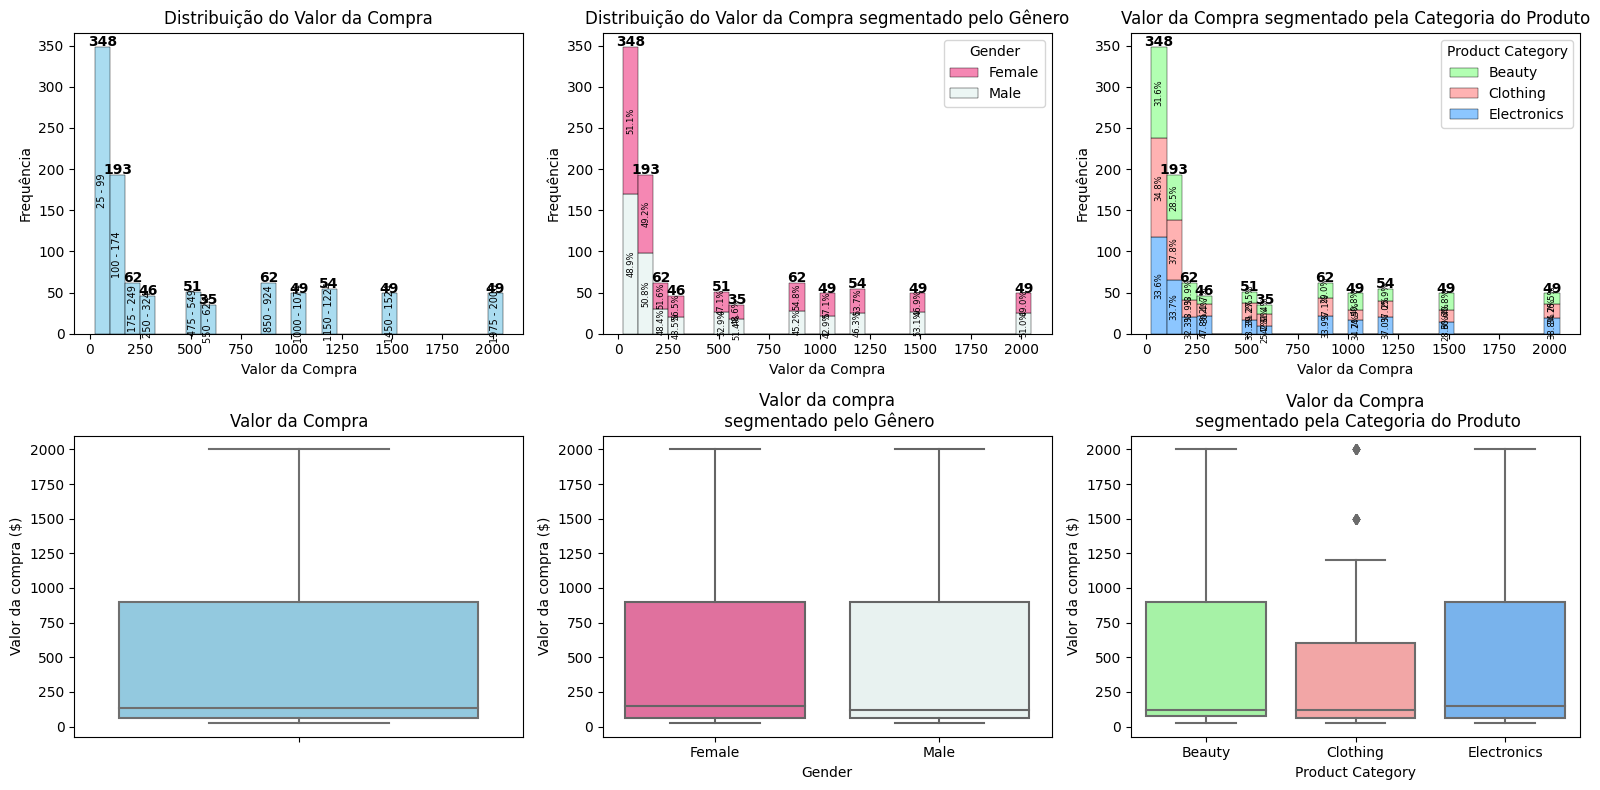

In [65]:
janela, graficos = plt.subplots(nrows=2, ncols=3, figsize=(16,8)) # Criação de um Grid 2x3 de gráficos

binwidth_value = 75  # Defina o tamanho do intervalo
fontsize = 7

# 📌 Gráfico 1 (Histograma)
histplot = sns.histplot(data=df, x='Total Amount', binwidth=binwidth_value, ax=graficos[0][0], edgecolor="black", alpha=0.7, linewidth=0.3, color='skyblue')
graficos[0][0].set_title('Distribuição do Valor da Compra', fontsize=12)
graficos[0][0].set_xlabel('Valor da Compra', fontsize=10)
graficos[0][0].set_ylabel("Frequência", fontsize=10)

cria_rotulos_barras(histrgrama=histplot, grid=graficos, posicao_grid=[0,0], fontsize= 10, binwidth_value=binwidth_value)

rotula_intervalo_bins(DataFrame=df, column='Total Amount', histrgrama=histplot, grid=graficos, posicao_grid=[0,0], fontsize=fontsize, binwidth_value=binwidth_value)

# 📌 Gráfico 2 (Histograma)
histplot2 = sns.histplot(data=df, x='Total Amount', hue='Gender', binwidth=binwidth_value, multiple="stack", ax=graficos[0][1], edgecolor="black", linewidth=0.3, palette=palete_gender)

cria_rotulos_barras(histrgrama=histplot, grid=graficos, posicao_grid=[0,1], fontsize= 10, binwidth_value=binwidth_value)

rotula_percentual_segmentado_barras(histograma=histplot2, grid=graficos, posicao_grid=[0,1], fontsize=6)

graficos[0][1].set_title('Distribuição do Valor da Compra segmentado pelo Gênero', fontsize=12)
graficos[0][1].set_xlabel('Valor da Compra', fontsize=10)
graficos[0][1].set_ylabel('Frequência', fontsize=10)

# 📌 Gráfico 3 (Histograma)
histplot3 = sns.histplot(data=df, x='Total Amount', hue='Product Category', binwidth=binwidth_value,  multiple="stack", ax=graficos[0][2], edgecolor="black", linewidth=0.3, palette=palette_product_category)

cria_rotulos_barras(histrgrama=histplot, grid=graficos, posicao_grid=[0,2], fontsize= 10, binwidth_value=binwidth_value)

rotula_percentual_segmentado_barras(histograma=histplot3, grid=graficos, posicao_grid=[0,2], fontsize=6)

graficos[0][2].set_title('Valor da Compra segmentado pela Categoria do Produto', fontsize=12)
graficos[0][2].set_xlabel('Valor da Compra', fontsize=10)
graficos[0][2].set_ylabel('Frequência', fontsize=10)


# 🎯 Gráfico 4 (Boxplot)
gerador_boxplot(data=df, y='Total Amount', eixos=graficos, valor_eixos=[1,0], title='Valor da Compra', y_label='Valor da compra ($)')
# 🎯 Gráfico 5 (Boxplot)
gerador_boxplot(data=df, y='Total Amount', x='Gender' ,eixos=graficos, valor_eixos=[1,1], title='Valor da compra\n segmentado pelo Gênero', y_label='Valor da compra ($)', palette=palete_gender)
# 🎯 Gráfico 6 (Boxplot)
gerador_boxplot(data=df, y='Total Amount', x='Product Category' ,eixos=graficos, valor_eixos=[1,2], title='Valor da Compra\n segmentado pela Categoria do Produto', y_label='Valor da compra ($)', palette=palette_product_category)

# Exibir os gráficos
plt.tight_layout()
plt.show()

In [66]:
df_amount_menor_500 = df[df['Total Amount'] <= 500]
len(df_amount_menor_500)

700

**Explicação:** Analisando o atributo ``Total Amount``(Valor da compra), observamos que os dados estão concentrados à esquerda do gráfico, indicando uma predominância de valores menores. Essa distribuição pode ser confirmada ao analisar o 1º Boxplot e Histograma, onde 70% da base de dados possui um ``Total Amount`` menor ou igual a **\$500**.

Para entender melhor o comportamento desses valores, iremos a seguir aplicar um 'zoom in' e focar na região onde está a maior parte dos dados, direcionando nossos esforços analíticos para essa faixa.

Ao segmentar o ``Total Amount`` por gênero, não identificamos um insight relevante. No entanto, ao analisar a categoria do produto, observamos que os itens da categoria "Clothing" apresentam menor variabilidade em relação às demais. Além disso, há outliers nessa categoria, o que pode indicar a presença de valores discrepantes.

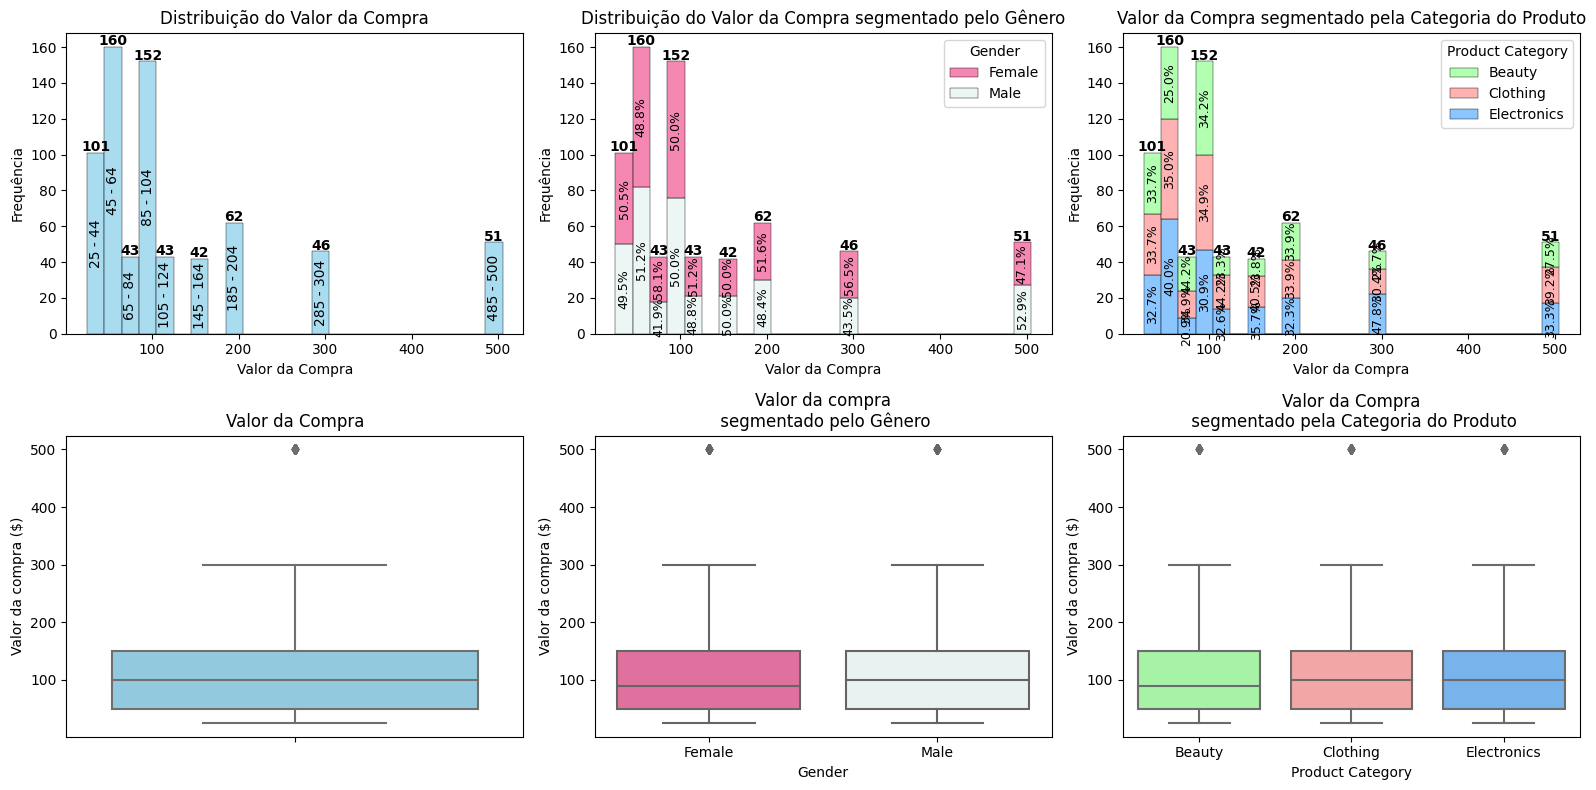

In [67]:
janela, graficos = plt.subplots(nrows=2, ncols=3, figsize=(16,8)) # Criação de um Grid 2x3 de gráficos

binwidth_value = 20  # Defina o tamanho do intervalo

# 📌 Gráfico 1 (Histograma)
histplot = sns.histplot(data=df_amount_menor_500, x='Total Amount', binwidth=binwidth_value, ax=graficos[0][0], color='skyblue', edgecolor="black", alpha=0.7, linewidth=0.3)
graficos[0][0].set_title('Distribuição do Valor da Compra', fontsize=12)
graficos[0][0].set_xlabel('Valor da Compra', fontsize=10)
graficos[0][0].set_ylabel("Frequência", fontsize=10)

cria_rotulos_barras(histrgrama=histplot, grid=graficos, posicao_grid=[0,0], fontsize= 10, binwidth_value=20)

rotula_intervalo_bins(DataFrame=df_amount_menor_500, column='Total Amount', histrgrama=histplot, grid=graficos, posicao_grid=[0,0], fontsize=10, binwidth_value=20)

# 📌 Gráfico 2 (Histograma)
histplot2 = sns.histplot(data=df_amount_menor_500, x='Total Amount', hue='Gender', binwidth=20, multiple="stack", ax=graficos[0][1], edgecolor="black", linewidth=0.3, palette=palete_gender)

cria_rotulos_barras(histrgrama=histplot, grid=graficos, posicao_grid=[0,1], fontsize= 10, binwidth_value=20)

rotula_percentual_segmentado_barras(histograma=histplot2, grid=graficos, posicao_grid=[0,1], fontsize=9)

graficos[0][1].set_title('Distribuição do Valor da Compra segmentado pelo Gênero', fontsize=12)
graficos[0][1].set_xlabel('Valor da Compra', fontsize=10)
graficos[0][1].set_ylabel('Frequência', fontsize=10)

# 📌 Gráfico 3 (Histograma)
histplot3 = sns.histplot(data=df_amount_menor_500, x='Total Amount', hue='Product Category', binwidth=20,  multiple="stack", ax=graficos[0][2], edgecolor="black", linewidth=0.3, palette=palette_product_category)

cria_rotulos_barras(histrgrama=histplot, grid=graficos, posicao_grid=[0,2], fontsize= 10, binwidth_value=20)

rotula_percentual_segmentado_barras(histograma=histplot3, grid=graficos, posicao_grid=[0,2], fontsize=9)

graficos[0][2].set_title('Valor da Compra segmentado pela Categoria do Produto', fontsize=12)
graficos[0][2].set_xlabel('Valor da Compra', fontsize=10)
graficos[0][2].set_ylabel('Frequência', fontsize=10)

# 🎯 Gráfico 4 (Boxplot)
gerador_boxplot(data=df_amount_menor_500, y='Total Amount', eixos=graficos, valor_eixos=[1,0], title='Valor da Compra', y_label='Valor da compra ($)')
# 🎯 Gráfico 5 (Boxplot)
gerador_boxplot(data=df_amount_menor_500, y='Total Amount', x='Gender' ,eixos=graficos, valor_eixos=[1,1], title='Valor da compra\n segmentado pelo Gênero', y_label='Valor da compra ($)', palette=palete_gender)
# 🎯 Gráfico 6 (Boxplot)
gerador_boxplot(data=df_amount_menor_500, y='Total Amount', x='Product Category' ,eixos=graficos, valor_eixos=[1,2], title='Valor da Compra\n segmentado pela Categoria do Produto', y_label='Valor da compra ($)', palette=palette_product_category)

# Exibir os gráficos
plt.tight_layout()
plt.show()

**Explicação**: Após analisarmos apenas as compras com valor menor ou igual a **\$500**, observamos que a maior frequência do ``Total Amount`` (valor da compra) está na faixa entre **\$45** e **\$64**. Esse é um insight relevante, pois abre possibilidades estratégicas, como a implementação de um programa de cashback para compras acima de um determinado valor ou a oferta de descontos direcionados a clientes dentro desse nicho.

Além disso, notamos que o valor de **\$500** já pode ser considerado um outlier, uma vez que está significativamente distante da maior parte dos dados.

### Análise Temporal

In [68]:
df.describe(include='datetime64[ns]')

,Date
count,998
mean,2023-07-02 15:40:45.691382784
min,2023-01-01 00:00:00
25%,2023-04-08 00:00:00
50%,2023-06-29 00:00:00
75%,2023-10-04 00:00:00
max,2023-12-31 00:00:00


**Conclusão**: Agora, vamos analisar o comportamento das vendas ao longo do tempo por meio de séries temporais. Uma série temporal é um conjunto de observações ordenadas cronologicamente, permitindo identificar padrões e tendências ao longo do período analisado.

Nossa base de dados contém todas as vendas realizadas no ano de 2023. Com essa análise, buscaremos entender como as vendas se comportaram ao longo do ano e identificar possíveis ações estratégicas para os anos seguintes, com o objetivo de impulsionar ainda mais o crescimento das vendas.

#### Atributo: ```Date```

In [69]:
df_serie_temporal = df.sort_values(by='Date').set_index('Date') # Ordenando e fazendo com que a coluna de data se torne um índice
df_serie_temporal = df_serie_temporal[['Quantity',  'Total Amount']] # Capturando apenas as colunas que iremos utilizar em nossas análises

# Criando um DataFrame com alguns valores agrupados por dia
df_vendas_por_dia = df_serie_temporal.resample('D').agg(
    Número_de_vendas=('Quantity', 'size'),  # Contagem de vendas por dia
    Valor_total_vendido=('Total Amount', 'sum'),  # Soma do total vendido por dia
    Qtd_produtos_vendidos=('Quantity', 'sum') # Quantidade de produtos vendidos por dia
)

quantidade_vendas_por_dia = df_vendas_por_dia['Número_de_vendas'] # Criando a série de vendas por dia
valor_vendas_por_dia = df_vendas_por_dia['Valor_total_vendido'] # Criando a série do valor total de vendas por dia
qtd_produtos_vendidos = df_vendas_por_dia['Qtd_produtos_vendidos']

datas_01 = quantidade_vendas_por_dia.index[quantidade_vendas_por_dia.index.day == 1] # Filtrando os dias 01 para usar como ticks no eixo X
labels_meses = [data.strftime('%b/%y') for data in datas_01] # Rótulos para o eixo X

# Adicionando um dicionários com os dias da semana para ser utilizado no futuro
dias_da_semana = {
    'Monday': 'Segunda feira',
    'Tuesday': 'Terça feira',
    'Wednesday': 'Quarta feira',
    'Thursday': 'Quinta feira',
    'Friday': 'Sexta feira',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
}


**Tendência & Sazonalidade & Ruídos**

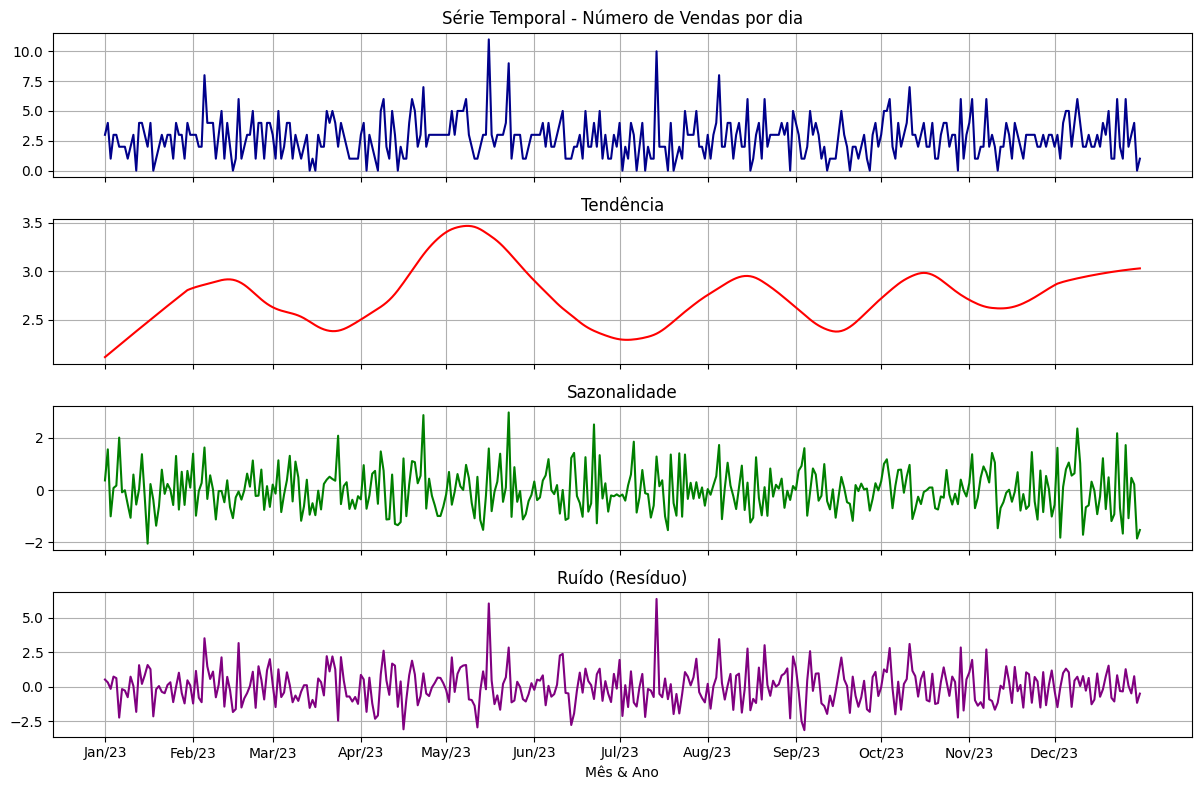

In [70]:
# Aplicando a decomposição STL
stl = STL(quantidade_vendas_por_dia, period=30)
resultado = stl.fit()

fig, axes = plt.subplots(4, 1, figsize=(12,8), sharex=True) # Criação de um Grid 2x3 de gráficos

# Série original
axes[0].plot(quantidade_vendas_por_dia.index, quantidade_vendas_por_dia.values, color="darkblue")
axes[0].set_title("Série Temporal - Número de Vendas por dia")
axes[0].grid()

# Tendência
axes[1].plot(resultado.trend.index, resultado.trend.values, color="red")
axes[1].set_title("Tendência")
axes[1].grid()

# Sazonalidade
axes[2].plot(resultado.seasonal.index, resultado.seasonal.values, color="green")
axes[2].set_title("Sazonalidade")
axes[2].grid()

# Ruído (resíduo)
axes[3].plot(resultado.resid.index, resultado.resid.values, color="purple")
axes[3].set_title("Ruído (Resíduo)")
axes[3].grid()

# Ajustando os rótulos do eixo X
axes[3].set_xticks(datas_01)
axes[3].set_xticklabels(labels_meses)  # Rotação para melhor visualização

plt.xlabel("Mês & Ano")
plt.tight_layout()
plt.show()


**Conclusão**: Ao observar a tendência, identificamos um comportamento cíclico ao longo do ano, com picos de vendas ocorrendo aproximadamente a cada trimestre. Esse padrão sugere que as vendas seguem um ritmo recorrente, possivelmente influenciado por fatores sazonais, como promoções, datas comemorativas ou ciclos naturais de consumo.

A sazonalidade revela flutuações previsíveis que se repetem em períodos regulares. Esses padrões podem indicar momentos estratégicos para intensificar campanhas de marketing ou ajustar estoques para atender à demanda de forma mais eficiente.

O ruído (resíduo) representa as variações aleatórias que não podem ser explicadas pela tendência ou sazonalidade. Em uma análise ideal, o ruído deve ser o menor possível, pois um alto nível de variação imprevisível pode dificultar a previsão de vendas e a tomada de decisões estratégicas.

**Quantidade de vendas & Valor Vendido por dia**

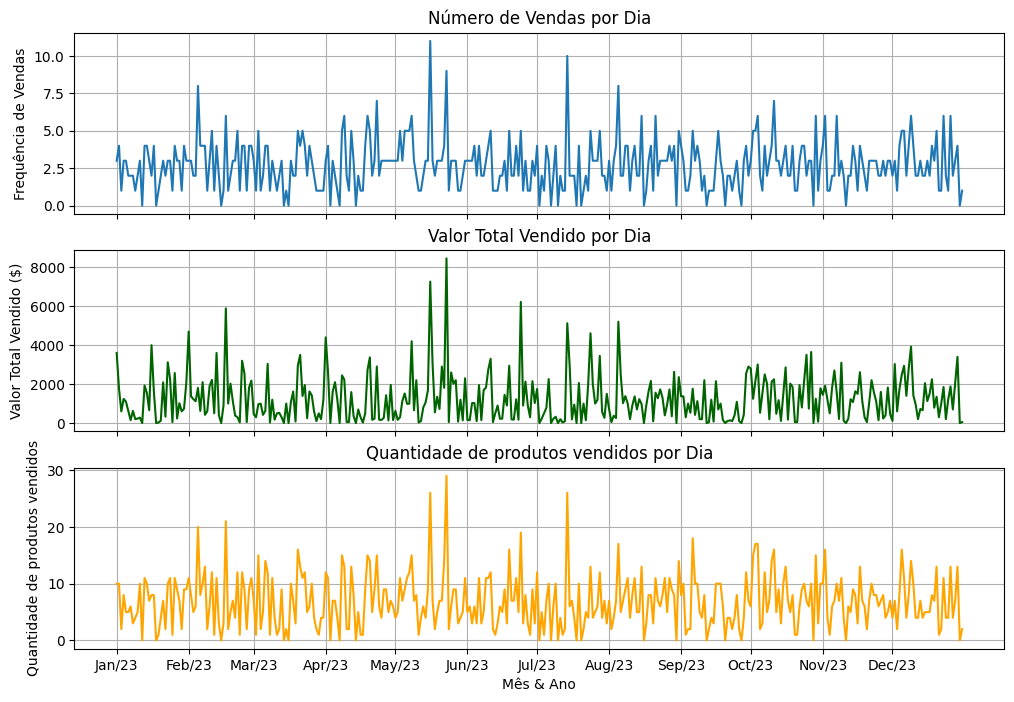

In [71]:
# Criando a figura com dois gráficos (subplots)
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# 📌 Gráfico 1 (Linha)
axs[0].plot(quantidade_vendas_por_dia.index, quantidade_vendas_por_dia.values, label="Total de Vendas")
axs[0].set_ylabel("Frequência de Vendas")
axs[0].set_title("Número de Vendas por Dia")
axs[0].grid()

# 📌 Gráfico 2 (Linha)
axs[1].plot(valor_vendas_por_dia.index, valor_vendas_por_dia.values, color='darkgreen')
axs[1].set_ylabel("Valor Total Vendido ($)")
axs[1].set_title("Valor Total Vendido por Dia")
axs[1].grid()

# 📌 Gráfico 3 (Linha)
axs[2].plot(qtd_produtos_vendidos.index, qtd_produtos_vendidos.values, color='orange')
axs[2].set_ylabel("Quantidade de produtos vendidos")
axs[2].set_title("Quantidade de produtos vendidos por Dia")
axs[2].grid()

# Ajustando o eixo X para exibir apenas os dias 01
plt.xticks(datas_01, labels_meses)
plt.xlabel("Mês & Ano")

# Mostrando o gráfico
plt.show()


**Conclusão**: Ao analisar a decomposição diária dos valores vendidos, da quantidade de itens comercializados e do número total de vendas, o segundo trimestre do ano se destaca como o período de maior volume de transações. Nesse intervalo, observamos os picos mais altos tanto no valor total das vendas quanto na quantidade de produtos vendidos.

Dentre esses meses, maio e junho se sobressaem, sendo os únicos meses do ano com registro de vendas em todos os dias, o que pode indicar uma demanda mais consistente nesse período. Esse padrão sugere oportunidades estratégicas, como intensificação de campanhas promocionais ou ajuste de estoques para maximizar o aproveitamento dessa alta sazonalidade.

Analisando os dias que tiveram os maiores valores vendidos

In [72]:
# Selecionando os 10 dias com maior número de vendas
vendas_detalhadas = df_vendas_por_dia.reset_index()
vendas_detalhadas['Mês'] = vendas_detalhadas['Date'].dt.month_name() # Adicionando o mês
vendas_detalhadas['Dia da Semana'] = vendas_detalhadas['Date'].dt.day_name() # Adicionando o dia da semana
vendas_detalhadas['Trimestre'] = vendas_detalhadas['Date'].dt.quarter # Adicionando o trimestre
vendas_detalhadas["Dia da Semana"] = vendas_detalhadas["Dia da Semana"].replace(dias_da_semana)

top_10_maiores_vendas = vendas_detalhadas.sort_values(by='Valor_total_vendido', ascending=False).head(10)
top_10_maiores_vendas

,Date,Número_de_vendas,Valor_total_vendido,Qtd_produtos_vendidos,Mês,Dia da Semana,Trimestre
142,2023-05-23,9,8455,29,May,Terça feira,2
135,2023-05-16,11,7260,26,May,Terça feira,2
174,2023-06-24,5,6220,19,June,Sábado,2
47,2023-02-17,6,5890,21,February,Sexta feira,1
216,2023-08-05,8,5205,17,August,Sábado,3
194,2023-07-14,10,5125,26,July,Sexta feira,3
31,2023-02-01,3,4700,11,February,Quarta feira,1
204,2023-07-24,5,4610,13,July,Segunda feira,3
90,2023-04-01,3,4400,12,April,Sábado,2
127,2023-05-08,6,4200,15,May,Segunda feira,2


**Conclusão**: Ao analisar os dias com os maiores volumes de vendas, identificamos que os valores totais mais altos foram registrados em maio, reforçando a importância desse mês para o desempenho geral.

Além disso, 7 dos 10 dias com maior faturamento ocorreram no primeiro semestre de 2023, sugerindo que esse período apresenta um comportamento de consumo mais intenso. Esse padrão pode indicar sazonalidade nas vendas, sendo relevante para o planejamento de estratégias promocionais e de estoque nos meses de maior demanda.

**Analisando os dias que hão houveram vendas**

In [73]:
sem_vendas = vendas_detalhadas[vendas_detalhadas['Número_de_vendas'] == 0]

percentual_dias_sem_venda = round((len(sem_vendas) / 365) * 100,2)
print(f'{percentual_dias_sem_venda}% dos dias de 2023 a loja não fez nenhuma venda, sendo ao todo {len(sem_vendas)} dias')

5.75% dos dias de 2023 a loja não fez nenhuma venda, sendo ao todo 21 dias


In [74]:
valor_nao_recebido = round(df_vendas_por_dia['Valor_total_vendido'].mean() * len(sem_vendas), 2)

print(f"Como não houve vendas ao longo de {len(sem_vendas)} dias no ano, a empresa deixou de receber em média aproximadamente ${valor_nao_recebido}")

Como não houve vendas ao longo de 21 dias no ano, a empresa deixou de receber em média aproximadamente $26147.59


In [75]:
sem_vendas

,Date,Número_de_vendas,Valor_total_vendido,Qtd_produtos_vendidos,Mês,Dia da Semana,Trimestre
11,2023-01-12,0,0,0,January,Quinta feira,1
17,2023-01-18,0,0,0,January,Quarta feira,1
45,2023-02-15,0,0,0,February,Quarta feira,1
72,2023-03-14,0,0,0,March,Terça feira,1
74,2023-03-16,0,0,0,March,Quinta feira,1
92,2023-04-03,0,0,0,April,Segunda feira,2
96,2023-04-07,0,0,0,April,Sexta feira,2
103,2023-04-14,0,0,0,April,Sexta feira,2
182,2023-07-02,0,0,0,July,Domingo,3
187,2023-07-07,0,0,0,July,Sexta feira,3


**Conclusão**: Ao longo do ano de 2023, 21 dias não registraram nenhuma venda, o que representa 5,75% do período analisado.

Se considerarmos a média diária de vendas, estimamos que a empresa deixou de faturar aproximadamente **\$26.163,93 devido** a essas três semanas sem movimentação.

Outro ponto relevante é que a maioria desses dias sem vendas ocorreu no segundo semestre de 2023, o que pode indicar uma redução no interesse dos clientes, mudanças sazonais ou até fatores operacionais que impactaram o desempenho.

**Analisando as vendas por dia da semana**

In [76]:
vendas_detalhadas.groupby('Dia da Semana')[['Número_de_vendas','Valor_total_vendido', 'Qtd_produtos_vendidos']].sum().sort_values(by='Valor_total_vendido', ascending=False)

,Número_de_vendas,Valor_total_vendido,Qtd_produtos_vendidos
Dia da Semana,,,
Sábado,150,78815,373
Terça feira,161,69440,397
Segunda feira,144,68720,381
Sexta feira,143,66290,373
Quarta feira,139,58770,356
Domingo,138,58600,329
Quinta feira,123,53835,301


**Conclusão**: Ao analisar o total vendido por dia da semana, identificamos que o sábado foi o dia com o maior volume de vendas, seguido pela segunda-feira.

Um dado interessante é que a terça-feira se destacou com o maior número de vendas e a maior quantidade de produtos vendidos por compra, porém, foi apenas o terceiro colocado em valor total vendido.

Isso sugere que, embora haja um alto volume de transações na terça-feira, o ticket médio das compras é menor. Uma possível estratégia seria implementar ações promocionais ou incentivos para aumentar o valor das compras nesse dia, aproveitando o potencial já existente e impulsionando ainda mais o faturamento

**Analisando as vendas por trimestre**

In [77]:
vendas_detalhadas.groupby('Trimestre')[['Número_de_vendas','Valor_total_vendido', 'Qtd_produtos_vendidos']].sum().sort_values(by='Valor_total_vendido', ascending=False)

,Número_de_vendas,Valor_total_vendido,Qtd_produtos_vendidos
Trimestre,,,
4,265,126190,664
2,268,123735,670
1,234,108500,603
3,231,96045,573


In [78]:
vendas_detalhadas.groupby('Trimestre')[['Número_de_vendas','Valor_total_vendido', 'Qtd_produtos_vendidos']].std().sort_values(by='Valor_total_vendido', ascending=False)

,Número_de_vendas,Valor_total_vendido,Qtd_produtos_vendidos
Trimestre,,,
2,1.821859,1540.944581,5.192979
1,1.505048,1178.100844,4.643347
3,1.775874,1112.703257,4.588814
4,1.539533,1004.850902,4.229218


**Conclusão**: Até aqui, ficou evidente que o segundo trimestre apresentou o melhor desempenho de vendas em todos os critérios analisados. No entanto, ao examinar o valor total vendido por trimestre, um insight inesperado surgiu: o último trimestre de 2023 (outubro, novembro e dezembro) registrou o maior montante em vendas.

Para validar essa observação, calculei o desvio padrão e obtive uma resposta interessante: o terceiro trimestre foi o período com a menor variabilidade em todos os critérios(Número de vendas, Valor total vendido e Quantidade de produtos vendidos). Isso indica que, embora outros trimestres tenham apresentado picos de vendas, o terceiro trimestre manteve um desempenho mais estável e previsível ao longo dos meses.

Essa estabilidade pode sugerir um comportamento mais consistente do mercado nesse período, o que pode ser explorado estrategicamente para planejamento de ações comerciais e campanhas futuras.

## 6. Conclusão

1. **Público sênior como oportunidade** <br>
Mais de 11% dos clientes na amostra têm 60 anos ou mais. Esse dado sugere uma oportunidade valiosa para investir em ações específicas voltadas a esse público, como programas de fidelização, descontos personalizados ou campanhas que destaquem produtos de maior interesse para essa faixa etária.

2. **Preferência por múltiplas compras** <br>
Cerca de 75% dos clientes tendem a comprar mais de um produto por vez, um insight essencial para estratégias de marketing. Uma abordagem eficaz seria incentivar a compra de combos de produtos, especialmente se segmentada para o público feminino e focada nas categorias "Clothing" e "Electronics", que já apresentam alta adesão.

3. **Desempenho inconsistente de produtos a \$30** <br>
Produtos com preço unitário de **\$30** são os menos adquiridos, o que é atípico, considerando que itens de **\$25** e **\$50** estão entre os mais vendidos. Uma possível estratégia seria reduzir o preço para **\$25** para aumentar a aceitação ou analisar se esse item deve ser mantido nas prateleiras.

4. **Faixa de preço ideal para maior faturamento** <br>
O maior volume de gastos ocorre na faixa de **\$45** a **\$64**, um insight estratégico para ações como programas de cashback para compras acima de determinado valor ou descontos direcionados a clientes que já compram dentro desse intervalo.

5. **Padrão sazonal nas vendas** <br>
As vendas apresentam picos trimestrais, com destaque para o segundo trimestre, que registrou um alto volume de vendas e itens vendidos. Maio e junho, especificamente, foram os únicos meses com vendas em todos os dias, sugerindo uma demanda mais consistente nesse período. Esse padrão indica uma excelente oportunidade para ações promocionais sazonais e ajustes estratégicos de estoque para maximizar o faturamento.

6. **Terceiro trimestre como líder em faturamento** <br>
Apesar do segundo trimestre ter o maior número de vendas, o terceiro trimestre registrou o maior valor total vendido. Isso sugere que, mesmo com menos transações, o ticket médio foi mais alto, uma informação crucial para definir estratégias de precificação e promoção nesse período.

7. **Impacto dos dias sem vendas** <br>
Em 2023, 21 dias não registraram nenhuma venda, representando 5,75% do ano. Com base na média diária de faturamento, estima-se que a empresa deixou de arrecadar aproximadamente **\$26.163,93** nesses dias. A concentração dessas 3 semanas sem vendas pode indicar sazonalidade ou desafios operacionais, merecendo uma análise mais aprofundada para reduzir perdas futuras.